<a href="https://colab.research.google.com/github/lucas-larsson/II142X/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II142X Degree project  VGG16 vs VGG32 a depper dive

- Alex Lindberg : alex5@kth.se
- Lucas Larsson : lulars@kth.se

In [1]:
# make sure we are running NVIDIA GPU V 100, specifically Tesla V100-SXM2-16GB, ended up running ion A 100
!nvidia-smi

Sun Apr 21 17:03:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Imports and setup

In [2]:
import torch
import torchvision
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Clone the git repos to accsess custom functions

!git clone https://github.com/lucas-larsson/II142X.git
%cd II142X/

Cloning into 'II142X'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 70 (delta 25), reused 41 (delta 16), pack-reused 0
Receiving objects: 100% (70/70), 2.72 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/II142X


In [4]:
# From local helper files

from helpers.evaluation import set_all_seeds, compute_confusion_matrix
from helpers.training import train_model
from helpers.plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helpers.data_importing import get_dataloaders_cifar10, UnNormalize, save_model, save_metrics
from helpers.plotting import plot_metric

## Settings and Dataset

In [5]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
set_all_seeds(RANDOM_SEED)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
results_dir = '/content/drive/My Drive/Colab Notebooks/II142X-Results/A100'

In [6]:
##########################
### CIFAR-10 DATASET
##########################

##  VGG 16, resize to 64x64

train_transforms_64 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms_64 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader_64, valid_loader_64, test_loader_64 = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms_64,
    test_transforms=test_transforms_64,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader_64:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

## VGG 23 resize to 128x128

train_transforms_128 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((140, 140)),
    torchvision.transforms.RandomCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms_128 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((140, 140)),
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader_128, valid_loader_128, test_loader_128 = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms_128,
    test_transforms=test_transforms_128,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader_128:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break


100%|██████████| 170498071/170498071 [00:12<00:00, 13135246.75it/s]


Extracting data/cifar-10-python.tar.gz to data


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])
Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([9, 7, 0, 5, 6, 9, 1, 7, 4, 5])


## Training and Testing

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 001/050 | Batch 0000/0175 | Loss: 3.9261
Epoch: 001/050 | Batch 0100/0175 | Loss: 2.3004
Epoch: 001/050 | Train Acc: 22.28% | Validation Acc: 23.52% | Precision: 0.2142 | Recall: 0.2317 | F1: 0.1698


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 002/050 | Batch 0000/0175 | Loss: 2.0432
Epoch: 002/050 | Batch 0100/0175 | Loss: 1.8842
Epoch: 002/050 | Train Acc: 38.48% | Validation Acc: 38.40% | Precision: 0.3816 | Recall: 0.3847 | F1: 0.3565


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 003/050 | Batch 0000/0175 | Loss: 1.6898
Epoch: 003/050 | Batch 0100/0175 | Loss: 1.6024
Epoch: 003/050 | Train Acc: 47.69% | Validation Acc: 47.62% | Precision: 0.4778 | Recall: 0.4759 | F1: 0.4607


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 004/050 | Batch 0000/0175 | Loss: 1.3431
Epoch: 004/050 | Batch 0100/0175 | Loss: 1.3254
Epoch: 004/050 | Train Acc: 54.68% | Validation Acc: 55.68% | Precision: 0.5779 | Recall: 0.5559 | F1: 0.5567


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 005/050 | Batch 0000/0175 | Loss: 1.3121
Epoch: 005/050 | Batch 0100/0175 | Loss: 1.3278
Epoch: 005/050 | Train Acc: 59.02% | Validation Acc: 59.10% | Precision: 0.6190 | Recall: 0.5914 | F1: 0.5832


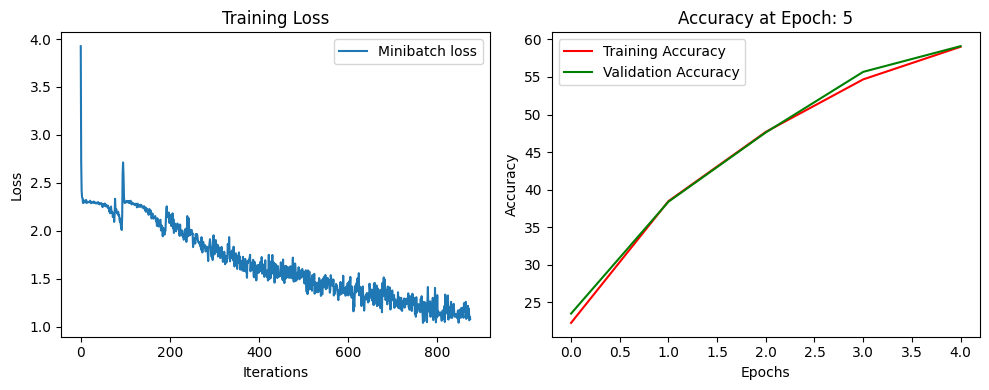

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 006/050 | Batch 0000/0175 | Loss: 1.1157
Epoch: 006/050 | Batch 0100/0175 | Loss: 1.1267
Epoch: 006/050 | Train Acc: 64.30% | Validation Acc: 63.78% | Precision: 0.6500 | Recall: 0.6401 | F1: 0.6264


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 007/050 | Batch 0000/0175 | Loss: 1.1435
Epoch: 007/050 | Batch 0100/0175 | Loss: 0.8205
Epoch: 007/050 | Train Acc: 71.02% | Validation Acc: 70.32% | Precision: 0.7039 | Recall: 0.7020 | F1: 0.7003


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 008/050 | Batch 0000/0175 | Loss: 0.8942
Epoch: 008/050 | Batch 0100/0175 | Loss: 0.8700
Epoch: 008/050 | Train Acc: 73.51% | Validation Acc: 72.66% | Precision: 0.7417 | Recall: 0.7262 | F1: 0.7241


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 009/050 | Batch 0000/0175 | Loss: 0.7022
Epoch: 009/050 | Batch 0100/0175 | Loss: 0.8191
Epoch: 009/050 | Train Acc: 77.51% | Validation Acc: 76.02% | Precision: 0.7626 | Recall: 0.7593 | F1: 0.7586


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 010/050 | Batch 0000/0175 | Loss: 0.6207
Epoch: 010/050 | Batch 0100/0175 | Loss: 0.6587
Epoch: 010/050 | Train Acc: 78.85% | Validation Acc: 77.34% | Precision: 0.7841 | Recall: 0.7743 | F1: 0.7735


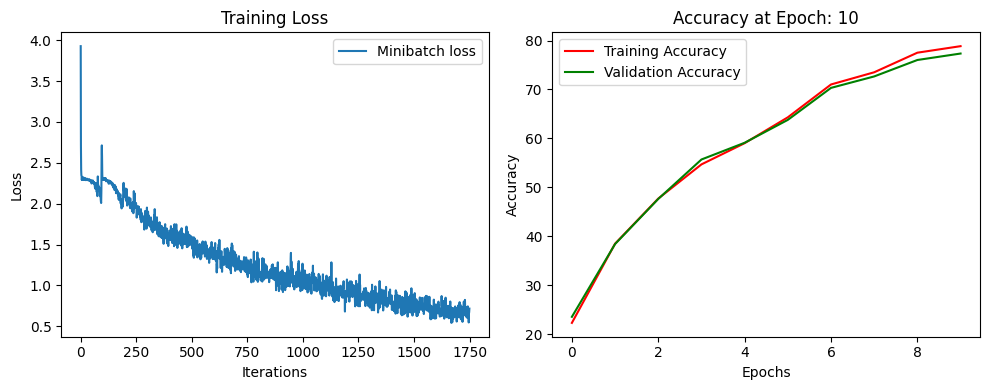

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 011/050 | Batch 0000/0175 | Loss: 0.5233
Epoch: 011/050 | Batch 0100/0175 | Loss: 0.6143
Epoch: 011/050 | Train Acc: 79.77% | Validation Acc: 76.14% | Precision: 0.7739 | Recall: 0.7625 | F1: 0.7602


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 012/050 | Batch 0000/0175 | Loss: 0.5776
Epoch: 012/050 | Batch 0100/0175 | Loss: 0.5263
Epoch: 012/050 | Train Acc: 82.64% | Validation Acc: 78.56% | Precision: 0.7910 | Recall: 0.7858 | F1: 0.7836


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 013/050 | Batch 0000/0175 | Loss: 0.5374
Epoch: 013/050 | Batch 0100/0175 | Loss: 0.5090
Epoch: 013/050 | Train Acc: 84.91% | Validation Acc: 80.00% | Precision: 0.8084 | Recall: 0.8012 | F1: 0.8003


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 014/050 | Batch 0000/0175 | Loss: 0.4217
Epoch: 014/050 | Batch 0100/0175 | Loss: 0.4544
Epoch: 014/050 | Train Acc: 85.09% | Validation Acc: 79.36% | Precision: 0.8054 | Recall: 0.7951 | F1: 0.7954


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 015/050 | Batch 0000/0175 | Loss: 0.4603
Epoch: 015/050 | Batch 0100/0175 | Loss: 0.4232
Epoch: 015/050 | Train Acc: 87.59% | Validation Acc: 81.04% | Precision: 0.8139 | Recall: 0.8105 | F1: 0.8100


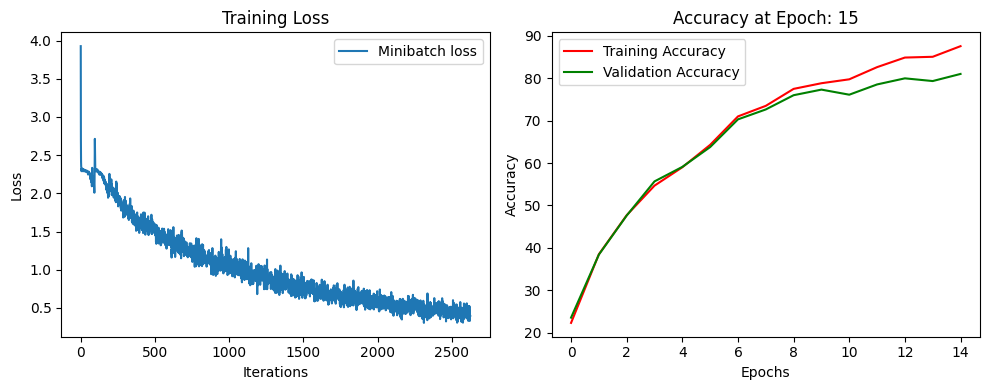

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 016/050 | Batch 0000/0175 | Loss: 0.3677
Epoch: 016/050 | Batch 0100/0175 | Loss: 0.3225
Epoch: 016/050 | Train Acc: 88.87% | Validation Acc: 81.72% | Precision: 0.8206 | Recall: 0.8173 | F1: 0.8160


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 017/050 | Batch 0000/0175 | Loss: 0.3257
Epoch: 017/050 | Batch 0100/0175 | Loss: 0.3594
Epoch: 017/050 | Train Acc: 89.34% | Validation Acc: 81.18% | Precision: 0.8274 | Recall: 0.8124 | F1: 0.8139


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 018/050 | Batch 0000/0175 | Loss: 0.3483
Epoch: 018/050 | Batch 0100/0175 | Loss: 0.3901
Epoch: 018/050 | Train Acc: 89.89% | Validation Acc: 81.06% | Precision: 0.8156 | Recall: 0.8101 | F1: 0.8098


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 019/050 | Batch 0000/0175 | Loss: 0.2201
Epoch: 019/050 | Batch 0100/0175 | Loss: 0.3876
Epoch: 019/050 | Train Acc: 91.94% | Validation Acc: 82.46% | Precision: 0.8291 | Recall: 0.8259 | F1: 0.8237


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 020/050 | Batch 0000/0175 | Loss: 0.2050
Epoch: 020/050 | Batch 0100/0175 | Loss: 0.2595
Epoch: 020/050 | Train Acc: 93.39% | Validation Acc: 83.50% | Precision: 0.8404 | Recall: 0.8349 | F1: 0.8367


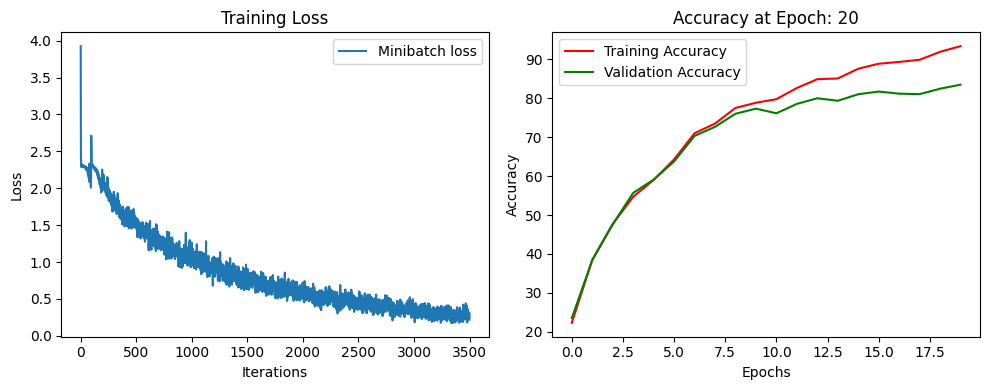

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 021/050 | Batch 0000/0175 | Loss: 0.1918
Epoch: 021/050 | Batch 0100/0175 | Loss: 0.2024
Epoch: 021/050 | Train Acc: 94.32% | Validation Acc: 83.18% | Precision: 0.8350 | Recall: 0.8318 | F1: 0.8314


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 022/050 | Batch 0000/0175 | Loss: 0.1222
Epoch: 022/050 | Batch 0100/0175 | Loss: 0.2917
Epoch: 022/050 | Train Acc: 93.96% | Validation Acc: 82.56% | Precision: 0.8278 | Recall: 0.8271 | F1: 0.8254


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 023/050 | Batch 0000/0175 | Loss: 0.2141
Epoch: 023/050 | Batch 0100/0175 | Loss: 0.2162


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 023/050 | Train Acc: 95.05% | Validation Acc: 83.24% | Precision: 0.8378 | Recall: 0.8327 | F1: 0.8329


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 024/050 | Batch 0000/0175 | Loss: 0.1296
Epoch: 024/050 | Batch 0100/0175 | Loss: 0.2705
Epoch: 024/050 | Train Acc: 95.48% | Validation Acc: 83.54% | Precision: 0.8357 | Recall: 0.8364 | F1: 0.8341


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 025/050 | Batch 0000/0175 | Loss: 0.1417
Epoch: 025/050 | Batch 0100/0175 | Loss: 0.2413
Epoch: 025/050 | Train Acc: 95.28% | Validation Acc: 83.44% | Precision: 0.8374 | Recall: 0.8350 | F1: 0.8345


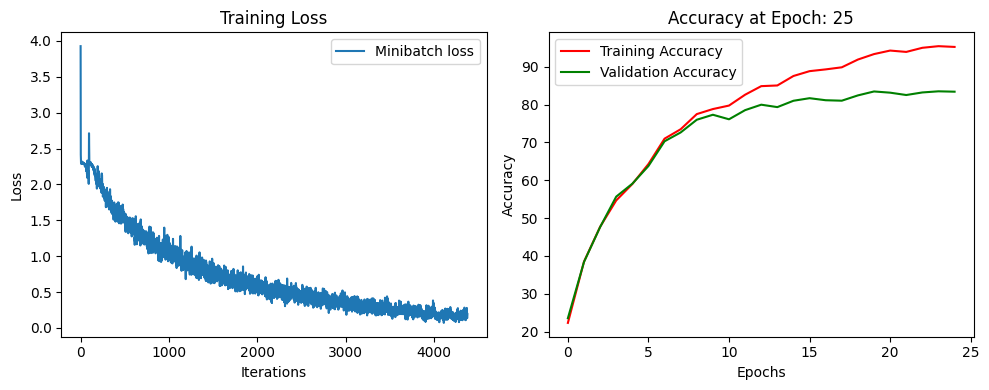

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 026/050 | Batch 0000/0175 | Loss: 0.1457
Epoch: 026/050 | Batch 0100/0175 | Loss: 0.1271
Epoch: 026/050 | Train Acc: 96.34% | Validation Acc: 83.26% | Precision: 0.8343 | Recall: 0.8337 | F1: 0.8324


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 027/050 | Batch 0000/0175 | Loss: 0.1611
Epoch: 027/050 | Batch 0100/0175 | Loss: 0.0981
Epoch: 027/050 | Train Acc: 97.28% | Validation Acc: 84.06% | Precision: 0.8412 | Recall: 0.8412 | F1: 0.8399


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 028/050 | Batch 0000/0175 | Loss: 0.1251
Epoch: 028/050 | Batch 0100/0175 | Loss: 0.1325
Epoch: 028/050 | Train Acc: 95.66% | Validation Acc: 83.04% | Precision: 0.8412 | Recall: 0.8299 | F1: 0.8318


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 029/050 | Batch 0000/0175 | Loss: 0.1357
Epoch: 029/050 | Batch 0100/0175 | Loss: 0.1281
Epoch: 029/050 | Train Acc: 97.32% | Validation Acc: 83.56% | Precision: 0.8373 | Recall: 0.8355 | F1: 0.8349


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 030/050 | Batch 0000/0175 | Loss: 0.0739
Epoch: 030/050 | Batch 0100/0175 | Loss: 0.1017
Epoch: 030/050 | Train Acc: 97.22% | Validation Acc: 83.40% | Precision: 0.8342 | Recall: 0.8355 | F1: 0.8328


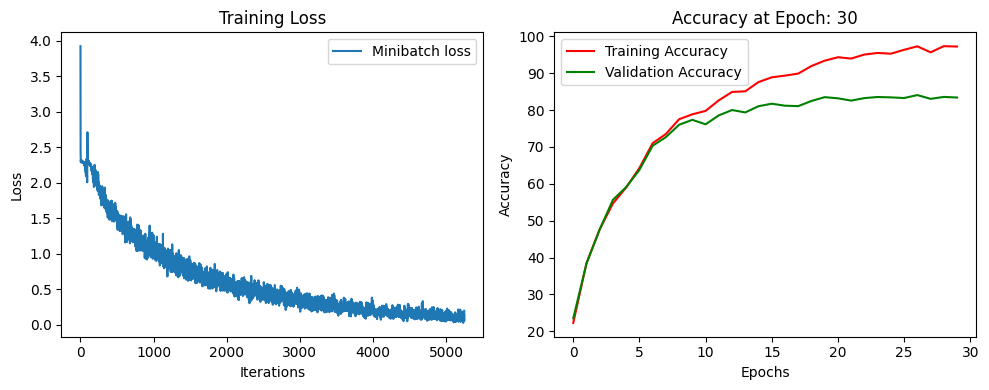

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 031/050 | Batch 0000/0175 | Loss: 0.0619
Epoch: 031/050 | Batch 0100/0175 | Loss: 0.0626
Epoch: 031/050 | Train Acc: 97.41% | Validation Acc: 83.60% | Precision: 0.8385 | Recall: 0.8373 | F1: 0.8361


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 032/050 | Batch 0000/0175 | Loss: 0.1128
Epoch: 032/050 | Batch 0100/0175 | Loss: 0.0874
Epoch: 032/050 | Train Acc: 96.13% | Validation Acc: 82.64% | Precision: 0.8330 | Recall: 0.8264 | F1: 0.8249


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 033/050 | Batch 0000/0175 | Loss: 0.1274
Epoch: 033/050 | Batch 0100/0175 | Loss: 0.0803
Epoch: 033/050 | Train Acc: 96.92% | Validation Acc: 82.92% | Precision: 0.8292 | Recall: 0.8305 | F1: 0.8272


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 034/050 | Batch 0000/0175 | Loss: 0.0982
Epoch: 034/050 | Batch 0100/0175 | Loss: 0.1195
Epoch: 034/050 | Train Acc: 97.54% | Validation Acc: 82.80% | Precision: 0.8360 | Recall: 0.8284 | F1: 0.8301


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 035/050 | Batch 0000/0175 | Loss: 0.1203
Epoch: 035/050 | Batch 0100/0175 | Loss: 0.0883
Epoch: 035/050 | Train Acc: 98.29% | Validation Acc: 84.00% | Precision: 0.8413 | Recall: 0.8408 | F1: 0.8400


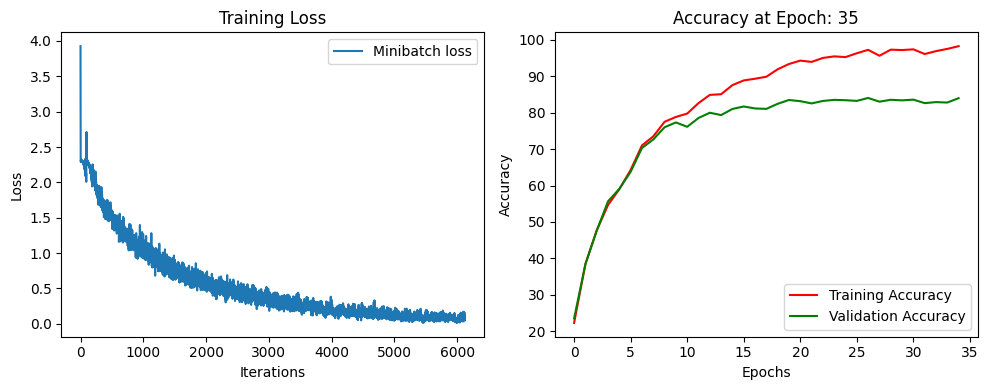

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 036/050 | Batch 0000/0175 | Loss: 0.0478
Epoch: 036/050 | Batch 0100/0175 | Loss: 0.0986
Epoch: 036/050 | Train Acc: 97.82% | Validation Acc: 83.48% | Precision: 0.8378 | Recall: 0.8360 | F1: 0.8344


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 037/050 | Batch 0000/0175 | Loss: 0.0401
Epoch: 037/050 | Batch 0100/0175 | Loss: 0.0254
Epoch: 037/050 | Train Acc: 98.23% | Validation Acc: 83.80% | Precision: 0.8414 | Recall: 0.8383 | F1: 0.8379


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 038/050 | Batch 0000/0175 | Loss: 0.0586
Epoch: 038/050 | Batch 0100/0175 | Loss: 0.0538
Epoch: 038/050 | Train Acc: 98.90% | Validation Acc: 84.96% | Precision: 0.8502 | Recall: 0.8501 | F1: 0.8490


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 039/050 | Batch 0000/0175 | Loss: 0.0225
Epoch: 039/050 | Batch 0100/0175 | Loss: 0.0367
Epoch: 039/050 | Train Acc: 98.77% | Validation Acc: 84.70% | Precision: 0.8461 | Recall: 0.8477 | F1: 0.8456


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 040/050 | Batch 0000/0175 | Loss: 0.0631
Epoch: 040/050 | Batch 0100/0175 | Loss: 0.0309
Epoch: 040/050 | Train Acc: 98.34% | Validation Acc: 83.68% | Precision: 0.8379 | Recall: 0.8372 | F1: 0.8363


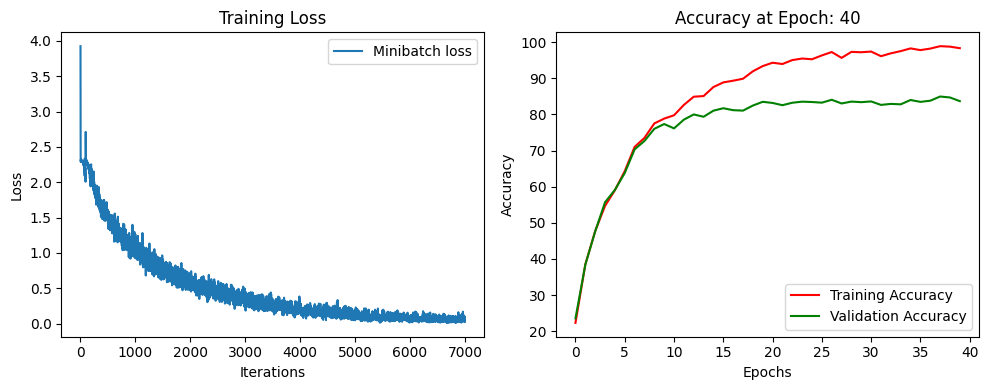

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 041/050 | Batch 0000/0175 | Loss: 0.0557
Epoch: 041/050 | Batch 0100/0175 | Loss: 0.0432
Epoch: 041/050 | Train Acc: 98.88% | Validation Acc: 84.38% | Precision: 0.8431 | Recall: 0.8440 | F1: 0.8426


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 042/050 | Batch 0000/0175 | Loss: 0.0236
Epoch: 042/050 | Batch 0100/0175 | Loss: 0.0152
Epoch: 042/050 | Train Acc: 98.99% | Validation Acc: 84.30% | Precision: 0.8447 | Recall: 0.8438 | F1: 0.8420


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 043/050 | Batch 0000/0175 | Loss: 0.0197
Epoch: 043/050 | Batch 0100/0175 | Loss: 0.0972
Epoch: 043/050 | Train Acc: 98.02% | Validation Acc: 83.40% | Precision: 0.8352 | Recall: 0.8349 | F1: 0.8298


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 044/050 | Batch 0000/0175 | Loss: 0.0762
Epoch: 044/050 | Batch 0100/0175 | Loss: 0.0216
Epoch: 044/050 | Train Acc: 98.76% | Validation Acc: 84.78% | Precision: 0.8503 | Recall: 0.8481 | F1: 0.8467


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 045/050 | Batch 0000/0175 | Loss: 0.0216
Epoch: 045/050 | Batch 0100/0175 | Loss: 0.0336
Epoch: 045/050 | Train Acc: 99.02% | Validation Acc: 84.54% | Precision: 0.8499 | Recall: 0.8455 | F1: 0.8465


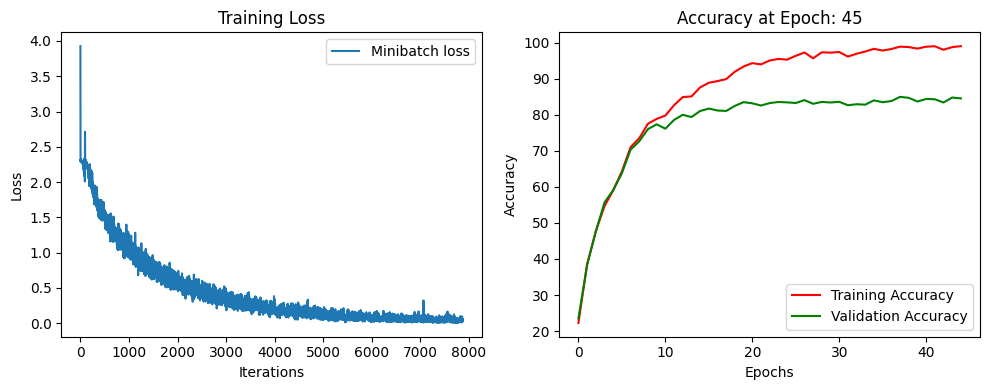

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 046/050 | Batch 0000/0175 | Loss: 0.0240
Epoch: 046/050 | Batch 0100/0175 | Loss: 0.0412
Epoch: 046/050 | Train Acc: 98.82% | Validation Acc: 84.56% | Precision: 0.8470 | Recall: 0.8466 | F1: 0.8448


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 047/050 | Batch 0000/0175 | Loss: 0.0429
Epoch: 047/050 | Batch 0100/0175 | Loss: 0.0451
Epoch: 047/050 | Train Acc: 98.91% | Validation Acc: 84.84% | Precision: 0.8563 | Recall: 0.8486 | F1: 0.8492


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 048/050 | Batch 0000/0175 | Loss: 0.0427
Epoch: 048/050 | Batch 0100/0175 | Loss: 0.0317
Epoch: 048/050 | Train Acc: 99.33% | Validation Acc: 84.96% | Precision: 0.8497 | Recall: 0.8506 | F1: 0.8497


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 049/050 | Batch 0000/0175 | Loss: 0.0270
Epoch: 049/050 | Batch 0100/0175 | Loss: 0.0820
Epoch: 049/050 | Train Acc: 99.02% | Validation Acc: 83.98% | Precision: 0.8429 | Recall: 0.8411 | F1: 0.8396


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 050/050 | Batch 0000/0175 | Loss: 0.0396
Epoch: 050/050 | Batch 0100/0175 | Loss: 0.0181
Epoch: 050/050 | Train Acc: 99.89% | Validation Acc: 85.48% | Precision: 0.8552 | Recall: 0.8552 | F1: 0.8550


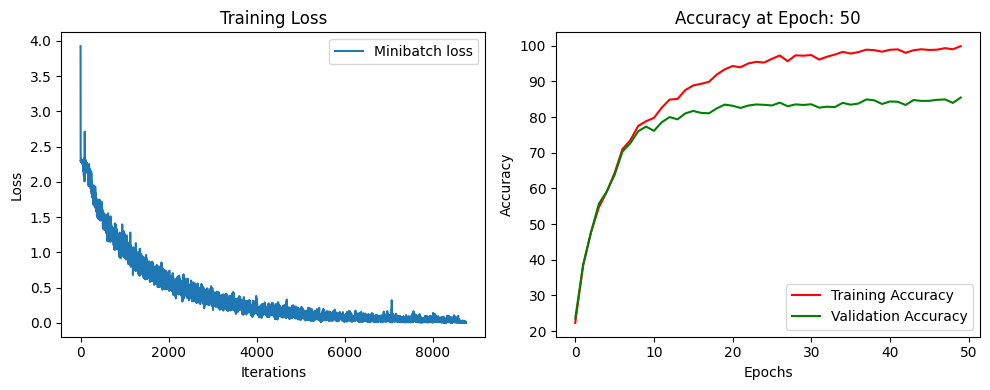

Total Training Time: 23.02 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Metrics | Accuracy: 85.72% | Precision: 0.8568 | Recall: 0.8572 | F1: 0.8566


In [8]:
from models.VGG_16 import VGG16

model_16 = VGG16(num_classes=10)
model_16 = model_16.to(DEVICE)

optimizer = torch.optim.SGD(model_16.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)
minibatch_loss_list_16, train_acc_list_16, valid_acc_list_16, valid_precision_list_16, valid_recall_list_16, valid_f1_list_16, test_acc_16, test_precision_16, test_recall_16, test_f1_16 = train_model(
    model=model_16,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_64,
    valid_loader=valid_loader_64,
    test_loader=test_loader_64,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

In [9]:
## Save the results

results_dir = '/content/drive/My Drive/Colab Notebooks/II142X-Results/A100'

save_model(model_16, 'VGG16', results_dir+'/models')


data_lists_16 = [minibatch_loss_list_16, train_acc_list_16, valid_acc_list_16, valid_precision_list_16,
                 valid_recall_list_16, valid_f1_list_16, [test_acc_16], [test_precision_16], [test_recall_16],
                 [test_f1_16]]
metrics_labels = [
    'minibatch_loss',
    'train_acc',
    'valid_acc',
    'valid_precision',
    'valid_recall',
    'valid_f1',
    'test_acc',
    'test_precision',
    'test_recall',
    'test_f1'
]

save_metrics(data_lists_16, metrics_labels, 'VGG16', results_dir)


Model VGG16 saved successfully at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/models/model_VGG16.pth
Saved minibatch_loss for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/minibatch_loss_VGG16.csv
Saved train_acc for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/train_acc_VGG16.csv
Saved valid_acc for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/valid_acc_VGG16.csv
Saved valid_precision for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/valid_precision_VGG16.csv
Saved valid_recall for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/valid_recall_VGG16.csv
Saved valid_f1 for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/valid_f1_VGG16.csv
Saved test_acc for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/test_acc_VGG16.csv
Saved test_precision for Model VGG16 at /content/drive

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 001/050 | Batch 0000/0175 | Loss: 2.7864
Epoch: 001/050 | Batch 0100/0175 | Loss: 2.0727
Epoch: 001/050 | Train Acc: 27.06% | Validation Acc: 26.84% | Precision: 0.3341 | Recall: 0.2716 | F1: 0.1939


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 002/050 | Batch 0000/0175 | Loss: 1.8644
Epoch: 002/050 | Batch 0100/0175 | Loss: 1.6675
Epoch: 002/050 | Train Acc: 40.67% | Validation Acc: 41.06% | Precision: 0.4038 | Recall: 0.4086 | F1: 0.3909


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 003/050 | Batch 0000/0175 | Loss: 1.6184
Epoch: 003/050 | Batch 0100/0175 | Loss: 1.5014
Epoch: 003/050 | Train Acc: 49.15% | Validation Acc: 49.44% | Precision: 0.5038 | Recall: 0.4948 | F1: 0.4944


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 004/050 | Batch 0000/0175 | Loss: 1.4197
Epoch: 004/050 | Batch 0100/0175 | Loss: 1.3732
Epoch: 004/050 | Train Acc: 51.96% | Validation Acc: 52.58% | Precision: 0.5811 | Recall: 0.5240 | F1: 0.5222


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 005/050 | Batch 0000/0175 | Loss: 1.2882
Epoch: 005/050 | Batch 0100/0175 | Loss: 1.1399
Epoch: 005/050 | Train Acc: 62.48% | Validation Acc: 62.50% | Precision: 0.6538 | Recall: 0.6240 | F1: 0.6234


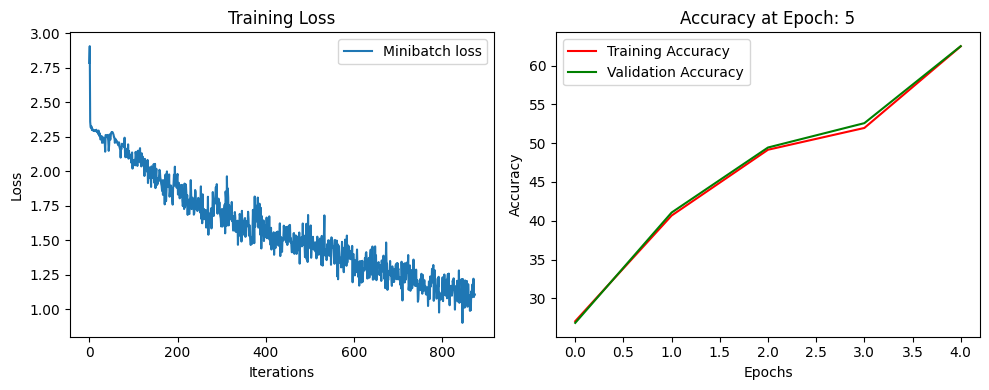

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 006/050 | Batch 0000/0175 | Loss: 0.9386
Epoch: 006/050 | Batch 0100/0175 | Loss: 0.9732
Epoch: 006/050 | Train Acc: 68.65% | Validation Acc: 67.86% | Precision: 0.7007 | Recall: 0.6784 | F1: 0.6845


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 007/050 | Batch 0000/0175 | Loss: 0.8844
Epoch: 007/050 | Batch 0100/0175 | Loss: 0.9042
Epoch: 007/050 | Train Acc: 71.11% | Validation Acc: 69.86% | Precision: 0.7179 | Recall: 0.6971 | F1: 0.6933


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 008/050 | Batch 0000/0175 | Loss: 0.7699
Epoch: 008/050 | Batch 0100/0175 | Loss: 0.7027
Epoch: 008/050 | Train Acc: 73.72% | Validation Acc: 71.58% | Precision: 0.7351 | Recall: 0.7154 | F1: 0.7159


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 009/050 | Batch 0000/0175 | Loss: 0.7609
Epoch: 009/050 | Batch 0100/0175 | Loss: 0.7171
Epoch: 009/050 | Train Acc: 77.99% | Validation Acc: 75.28% | Precision: 0.7661 | Recall: 0.7525 | F1: 0.7524


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 010/050 | Batch 0000/0175 | Loss: 0.5975
Epoch: 010/050 | Batch 0100/0175 | Loss: 0.5387
Epoch: 010/050 | Train Acc: 82.99% | Validation Acc: 78.54% | Precision: 0.7890 | Recall: 0.7861 | F1: 0.7851


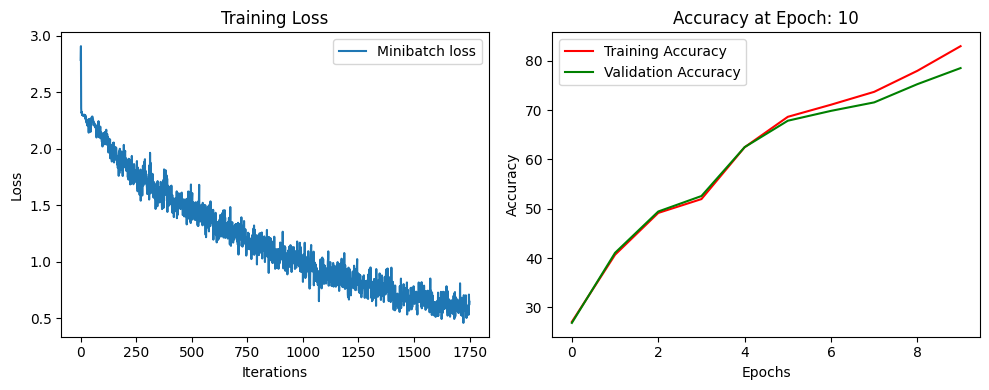

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 011/050 | Batch 0000/0175 | Loss: 0.3924
Epoch: 011/050 | Batch 0100/0175 | Loss: 0.6236
Epoch: 011/050 | Train Acc: 80.79% | Validation Acc: 77.02% | Precision: 0.7904 | Recall: 0.7702 | F1: 0.7735


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 012/050 | Batch 0000/0175 | Loss: 0.4659
Epoch: 012/050 | Batch 0100/0175 | Loss: 0.4610
Epoch: 012/050 | Train Acc: 86.09% | Validation Acc: 80.68% | Precision: 0.8101 | Recall: 0.8069 | F1: 0.8064


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 013/050 | Batch 0000/0175 | Loss: 0.4384
Epoch: 013/050 | Batch 0100/0175 | Loss: 0.3575
Epoch: 013/050 | Train Acc: 86.53% | Validation Acc: 80.72% | Precision: 0.8142 | Recall: 0.8070 | F1: 0.8082


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 014/050 | Batch 0000/0175 | Loss: 0.3370
Epoch: 014/050 | Batch 0100/0175 | Loss: 0.3649
Epoch: 014/050 | Train Acc: 87.50% | Validation Acc: 80.84% | Precision: 0.8270 | Recall: 0.8076 | F1: 0.8093


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 015/050 | Batch 0000/0175 | Loss: 0.4178
Epoch: 015/050 | Batch 0100/0175 | Loss: 0.2585
Epoch: 015/050 | Train Acc: 91.04% | Validation Acc: 82.80% | Precision: 0.8305 | Recall: 0.8289 | F1: 0.8275


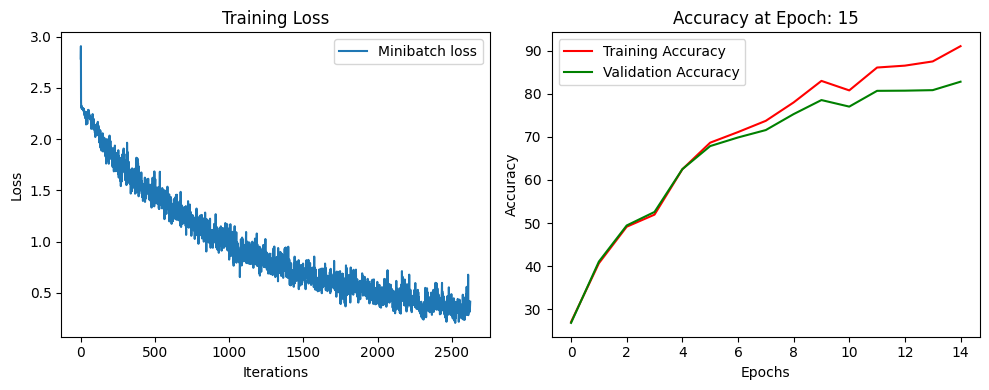

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 016/050 | Batch 0000/0175 | Loss: 0.2385
Epoch: 016/050 | Batch 0100/0175 | Loss: 0.3447
Epoch: 016/050 | Train Acc: 92.49% | Validation Acc: 82.66% | Precision: 0.8330 | Recall: 0.8265 | F1: 0.8285


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 017/050 | Batch 0000/0175 | Loss: 0.1489
Epoch: 017/050 | Batch 0100/0175 | Loss: 0.3639
Epoch: 017/050 | Train Acc: 93.34% | Validation Acc: 83.04% | Precision: 0.8330 | Recall: 0.8305 | F1: 0.8295


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 018/050 | Batch 0000/0175 | Loss: 0.2536
Epoch: 018/050 | Batch 0100/0175 | Loss: 0.2845
Epoch: 018/050 | Train Acc: 92.04% | Validation Acc: 82.10% | Precision: 0.8292 | Recall: 0.8225 | F1: 0.8211


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 019/050 | Batch 0000/0175 | Loss: 0.2596
Epoch: 019/050 | Batch 0100/0175 | Loss: 0.2302
Epoch: 019/050 | Train Acc: 94.95% | Validation Acc: 83.20% | Precision: 0.8337 | Recall: 0.8324 | F1: 0.8315


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 020/050 | Batch 0000/0175 | Loss: 0.1773
Epoch: 020/050 | Batch 0100/0175 | Loss: 0.1092
Epoch: 020/050 | Train Acc: 95.64% | Validation Acc: 83.06% | Precision: 0.8346 | Recall: 0.8318 | F1: 0.8300


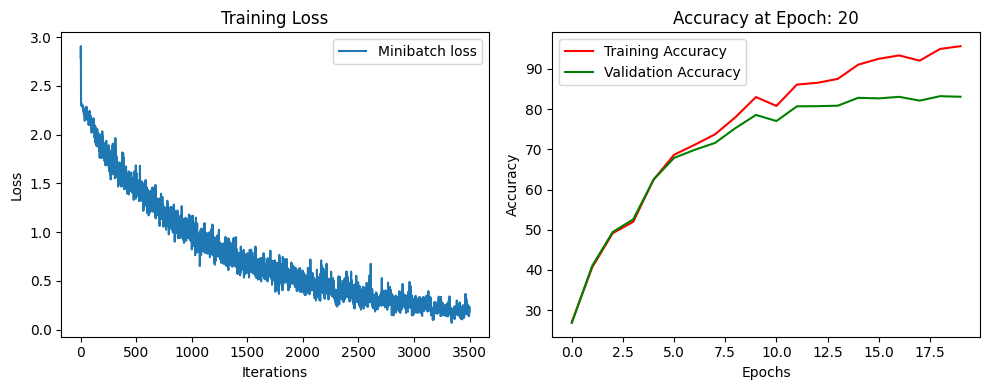

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 021/050 | Batch 0000/0175 | Loss: 0.1584
Epoch: 021/050 | Batch 0100/0175 | Loss: 0.1455
Epoch: 021/050 | Train Acc: 96.02% | Validation Acc: 82.82% | Precision: 0.8303 | Recall: 0.8294 | F1: 0.8273


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 022/050 | Batch 0000/0175 | Loss: 0.0951
Epoch: 022/050 | Batch 0100/0175 | Loss: 0.0997
Epoch: 022/050 | Train Acc: 93.79% | Validation Acc: 82.40% | Precision: 0.8487 | Recall: 0.8252 | F1: 0.8278


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 023/050 | Batch 0000/0175 | Loss: 0.1436
Epoch: 023/050 | Batch 0100/0175 | Loss: 0.1124
Epoch: 023/050 | Train Acc: 96.96% | Validation Acc: 83.22% | Precision: 0.8357 | Recall: 0.8323 | F1: 0.8312


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 024/050 | Batch 0000/0175 | Loss: 0.0954
Epoch: 024/050 | Batch 0100/0175 | Loss: 0.1167
Epoch: 024/050 | Train Acc: 96.81% | Validation Acc: 83.16% | Precision: 0.8448 | Recall: 0.8310 | F1: 0.8342


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 025/050 | Batch 0000/0175 | Loss: 0.0690
Epoch: 025/050 | Batch 0100/0175 | Loss: 0.1190
Epoch: 025/050 | Train Acc: 97.31% | Validation Acc: 83.14% | Precision: 0.8335 | Recall: 0.8324 | F1: 0.8314


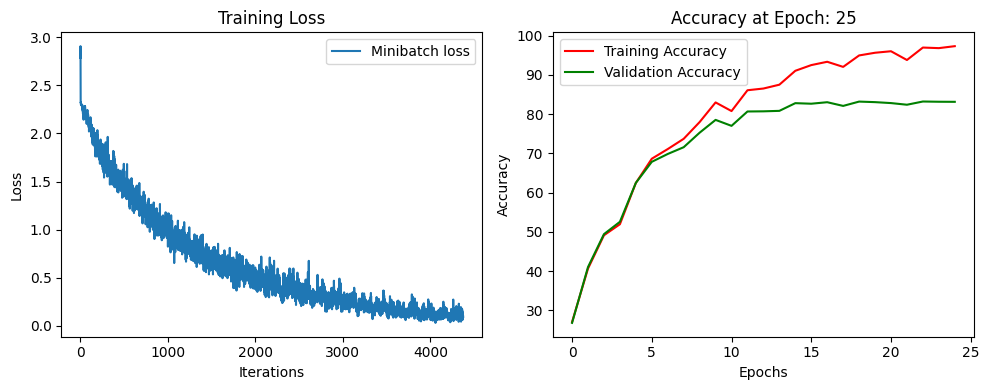

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 026/050 | Batch 0000/0175 | Loss: 0.0808
Epoch: 026/050 | Batch 0100/0175 | Loss: 0.0451
Epoch: 026/050 | Train Acc: 97.44% | Validation Acc: 83.76% | Precision: 0.8397 | Recall: 0.8377 | F1: 0.8367


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 027/050 | Batch 0000/0175 | Loss: 0.0447
Epoch: 027/050 | Batch 0100/0175 | Loss: 0.1416
Epoch: 027/050 | Train Acc: 97.87% | Validation Acc: 83.52% | Precision: 0.8380 | Recall: 0.8355 | F1: 0.8342


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 028/050 | Batch 0000/0175 | Loss: 0.0731
Epoch: 028/050 | Batch 0100/0175 | Loss: 0.0756
Epoch: 028/050 | Train Acc: 97.74% | Validation Acc: 83.22% | Precision: 0.8324 | Recall: 0.8339 | F1: 0.8316


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 029/050 | Batch 0000/0175 | Loss: 0.0663
Epoch: 029/050 | Batch 0100/0175 | Loss: 0.0482
Epoch: 029/050 | Train Acc: 96.97% | Validation Acc: 82.54% | Precision: 0.8329 | Recall: 0.8254 | F1: 0.8249


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 030/050 | Batch 0000/0175 | Loss: 0.0636
Epoch: 030/050 | Batch 0100/0175 | Loss: 0.0428
Epoch: 030/050 | Train Acc: 97.73% | Validation Acc: 83.18% | Precision: 0.8413 | Recall: 0.8319 | F1: 0.8343


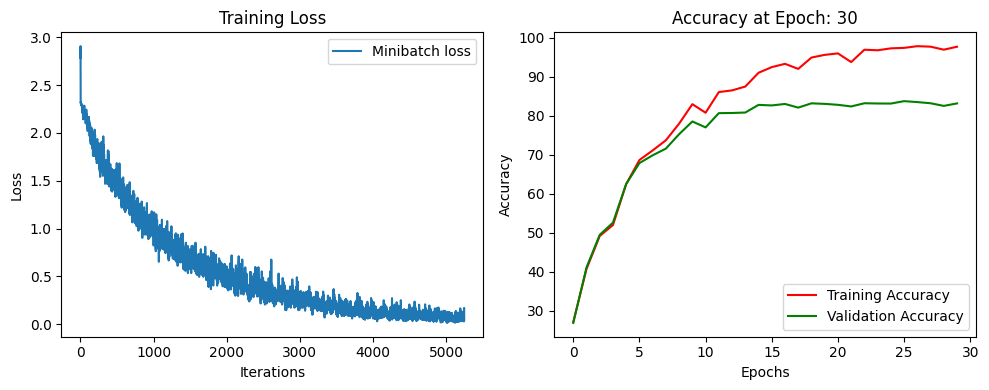

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 031/050 | Batch 0000/0175 | Loss: 0.0797
Epoch: 031/050 | Batch 0100/0175 | Loss: 0.0904
Epoch: 031/050 | Train Acc: 98.91% | Validation Acc: 84.82% | Precision: 0.8485 | Recall: 0.8492 | F1: 0.8476


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 032/050 | Batch 0000/0175 | Loss: 0.0417
Epoch: 032/050 | Batch 0100/0175 | Loss: 0.0745
Epoch: 032/050 | Train Acc: 98.63% | Validation Acc: 84.34% | Precision: 0.8438 | Recall: 0.8435 | F1: 0.8426


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 033/050 | Batch 0000/0175 | Loss: 0.0480
Epoch: 033/050 | Batch 0100/0175 | Loss: 0.0488
Epoch: 033/050 | Train Acc: 98.85% | Validation Acc: 84.42% | Precision: 0.8483 | Recall: 0.8444 | F1: 0.8438


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 034/050 | Batch 0000/0175 | Loss: 0.0842
Epoch: 034/050 | Batch 0100/0175 | Loss: 0.0472
Epoch: 034/050 | Train Acc: 98.21% | Validation Acc: 83.66% | Precision: 0.8476 | Recall: 0.8367 | F1: 0.8396


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 035/050 | Batch 0000/0175 | Loss: 0.0359
Epoch: 035/050 | Batch 0100/0175 | Loss: 0.0461
Epoch: 035/050 | Train Acc: 99.00% | Validation Acc: 84.00% | Precision: 0.8390 | Recall: 0.8412 | F1: 0.8389


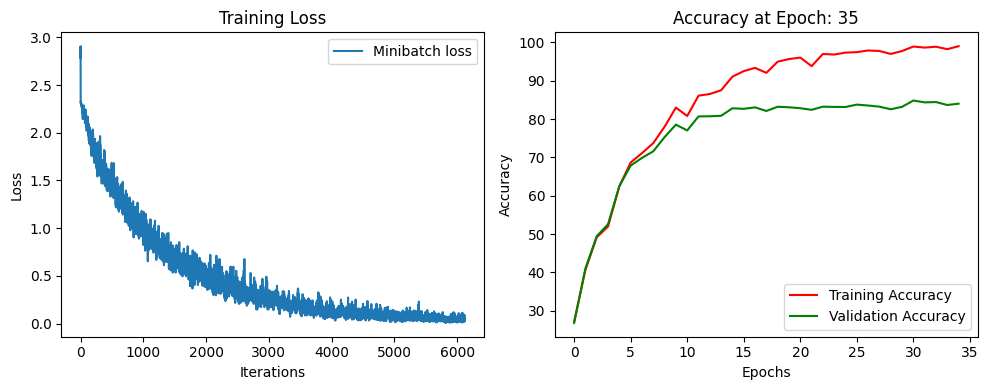

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 036/050 | Batch 0000/0175 | Loss: 0.0226
Epoch: 036/050 | Batch 0100/0175 | Loss: 0.0622
Epoch: 036/050 | Train Acc: 99.10% | Validation Acc: 84.54% | Precision: 0.8484 | Recall: 0.8455 | F1: 0.8456


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 037/050 | Batch 0000/0175 | Loss: 0.0264
Epoch: 037/050 | Batch 0100/0175 | Loss: 0.0135
Epoch: 037/050 | Train Acc: 98.77% | Validation Acc: 84.08% | Precision: 0.8425 | Recall: 0.8409 | F1: 0.8401


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 038/050 | Batch 0000/0175 | Loss: 0.0488
Epoch: 038/050 | Batch 0100/0175 | Loss: 0.0324
Epoch: 038/050 | Train Acc: 99.17% | Validation Acc: 85.42% | Precision: 0.8553 | Recall: 0.8553 | F1: 0.8541


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 039/050 | Batch 0000/0175 | Loss: 0.0372
Epoch: 039/050 | Batch 0100/0175 | Loss: 0.0300
Epoch: 039/050 | Train Acc: 99.23% | Validation Acc: 84.22% | Precision: 0.8441 | Recall: 0.8428 | F1: 0.8416


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 040/050 | Batch 0000/0175 | Loss: 0.0162
Epoch: 040/050 | Batch 0100/0175 | Loss: 0.0205
Epoch: 040/050 | Train Acc: 98.70% | Validation Acc: 83.86% | Precision: 0.8389 | Recall: 0.8394 | F1: 0.8366


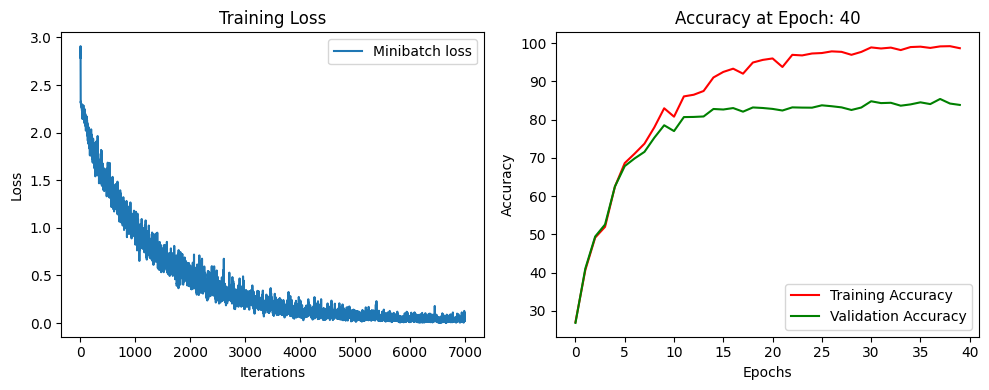

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 041/050 | Batch 0000/0175 | Loss: 0.0338
Epoch: 041/050 | Batch 0100/0175 | Loss: 0.0206
Epoch: 041/050 | Train Acc: 99.18% | Validation Acc: 84.42% | Precision: 0.8467 | Recall: 0.8441 | F1: 0.8440


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 042/050 | Batch 0000/0175 | Loss: 0.0150
Epoch: 042/050 | Batch 0100/0175 | Loss: 0.0235
Epoch: 042/050 | Train Acc: 99.11% | Validation Acc: 84.52% | Precision: 0.8495 | Recall: 0.8454 | F1: 0.8460


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 043/050 | Batch 0000/0175 | Loss: 0.0259
Epoch: 043/050 | Batch 0100/0175 | Loss: 0.0344
Epoch: 043/050 | Train Acc: 99.12% | Validation Acc: 84.48% | Precision: 0.8477 | Recall: 0.8450 | F1: 0.8449


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 044/050 | Batch 0000/0175 | Loss: 0.0197
Epoch: 044/050 | Batch 0100/0175 | Loss: 0.0156
Epoch: 044/050 | Train Acc: 98.70% | Validation Acc: 83.62% | Precision: 0.8503 | Recall: 0.8364 | F1: 0.8383


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 045/050 | Batch 0000/0175 | Loss: 0.0328
Epoch: 045/050 | Batch 0100/0175 | Loss: 0.0301
Epoch: 045/050 | Train Acc: 99.35% | Validation Acc: 84.64% | Precision: 0.8462 | Recall: 0.8468 | F1: 0.8450


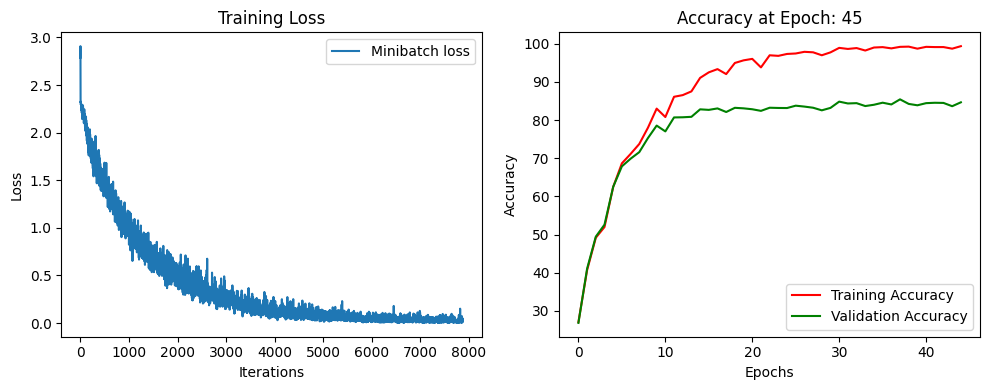

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 046/050 | Batch 0000/0175 | Loss: 0.0104
Epoch: 046/050 | Batch 0100/0175 | Loss: 0.0051
Epoch: 046/050 | Train Acc: 99.45% | Validation Acc: 84.92% | Precision: 0.8502 | Recall: 0.8493 | F1: 0.8480


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 047/050 | Batch 0000/0175 | Loss: 0.0199
Epoch: 047/050 | Batch 0100/0175 | Loss: 0.0273
Epoch: 047/050 | Train Acc: 99.50% | Validation Acc: 84.94% | Precision: 0.8517 | Recall: 0.8495 | F1: 0.8498


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 048/050 | Batch 0000/0175 | Loss: 0.0045
Epoch: 048/050 | Batch 0100/0175 | Loss: 0.0065
Epoch: 048/050 | Train Acc: 99.36% | Validation Acc: 84.52% | Precision: 0.8455 | Recall: 0.8460 | F1: 0.8442


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 049/050 | Batch 0000/0175 | Loss: 0.0107
Epoch: 049/050 | Batch 0100/0175 | Loss: 0.0395
Epoch: 049/050 | Train Acc: 99.28% | Validation Acc: 85.02% | Precision: 0.8570 | Recall: 0.8505 | F1: 0.8516


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 050/050 | Batch 0000/0175 | Loss: 0.0073
Epoch: 050/050 | Batch 0100/0175 | Loss: 0.0040
Epoch: 050/050 | Train Acc: 99.93% | Validation Acc: 86.44% | Precision: 0.8648 | Recall: 0.8645 | F1: 0.8642


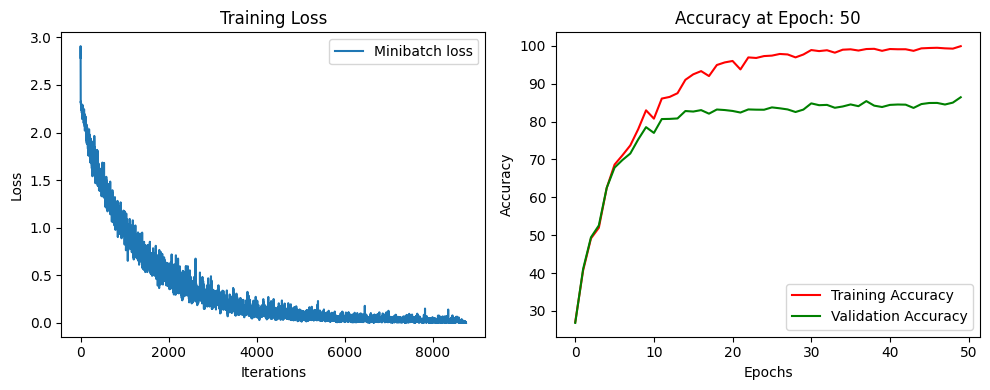

Total Training Time: 51.44 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Metrics | Accuracy: 85.48% | Precision: 0.8540 | Recall: 0.8548 | F1: 0.8541


In [10]:
from models.VGG_23 import VGG23

model_23 = VGG23(num_classes=10)
model_23 = model_23.to(DEVICE)

optimizer = torch.optim.SGD(model_23.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list_23, train_acc_list_23, valid_acc_list_23, valid_precision_list_23, valid_recall_list_23, valid_f1_list_23, test_acc_23, test_precision_23, test_recall_23, test_f1_23 = train_model(
    model=model_23,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_128,
    valid_loader=valid_loader_128,
    test_loader=test_loader_128,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

In [11]:
## Save the results

save_model(model_23, 'VGG23', results_dir+'/models')

data_lists_23 = [
    minibatch_loss_list_23,
    train_acc_list_23,
    valid_acc_list_23,
    valid_precision_list_23,
    valid_recall_list_23,
    valid_f1_list_23,
    [test_acc_23],
    [test_precision_23],
    [test_recall_23],
    [test_f1_23]
]
metrics_labels = [
    'minibatch_loss',
    'train_acc',
    'valid_acc',
    'valid_precision',
    'valid_recall',
    'valid_f1',
    'test_acc',
    'test_precision',
    'test_recall',
    'test_f1'
]

save_metrics(data_lists_23, metrics_labels, 'VGG23', results_dir)


Model VGG23 saved successfully at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/models/model_VGG23.pth
Saved minibatch_loss for Model VGG23 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/minibatch_loss_VGG23.csv
Saved train_acc for Model VGG23 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/train_acc_VGG23.csv
Saved valid_acc for Model VGG23 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/valid_acc_VGG23.csv
Saved valid_precision for Model VGG23 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/valid_precision_VGG23.csv
Saved valid_recall for Model VGG23 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/valid_recall_VGG23.csv
Saved valid_f1 for Model VGG23 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/valid_f1_VGG23.csv
Saved test_acc for Model VGG23 at /content/drive/My Drive/Colab Notebooks/II142X-Results/A100/test_acc_VGG23.csv
Saved test_precision for Model VGG23 at /content/drive

## Visualizing the results

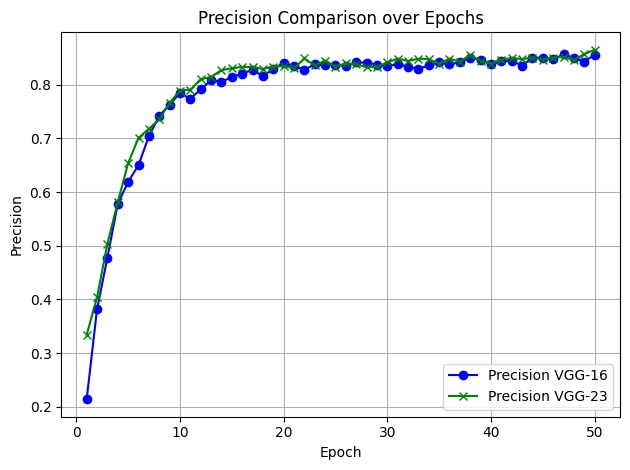

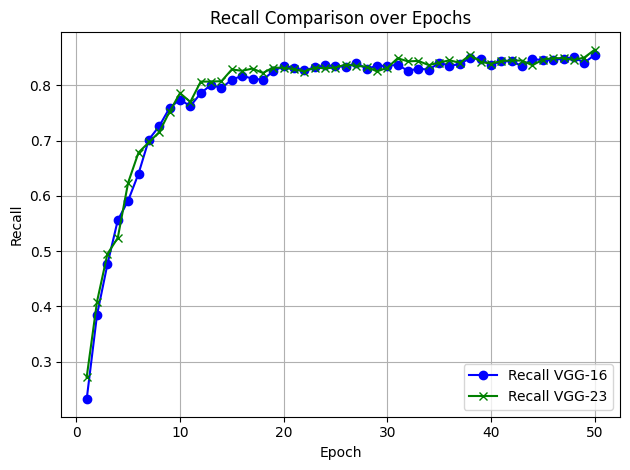

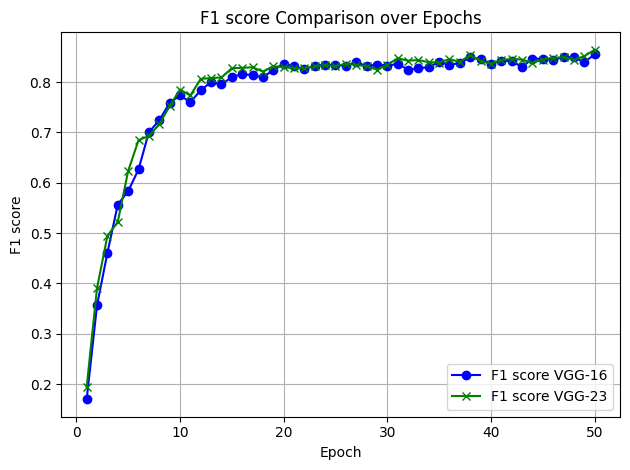

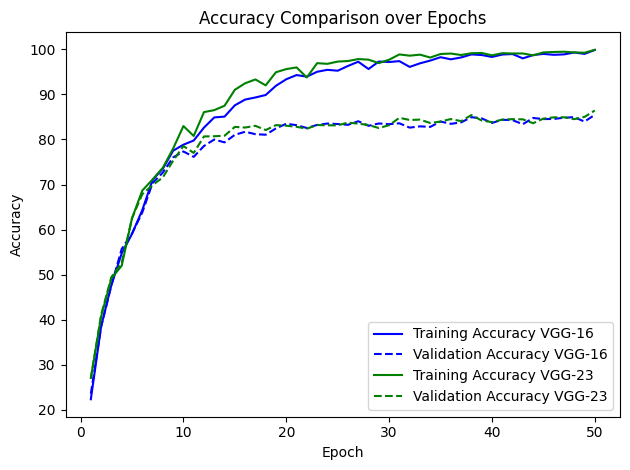

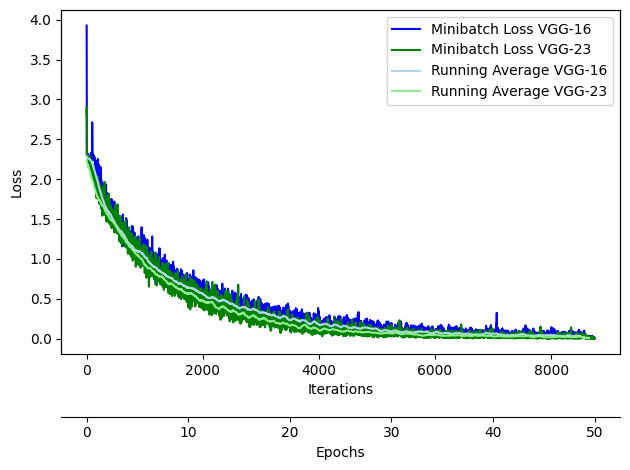

In [12]:
## Plotting the results

plot_metric(valid_precision_list_16, valid_precision_list_23, 'Precision', results_dir)
plot_metric(valid_recall_list_16, valid_recall_list_23, 'Recall', results_dir)
plot_metric(valid_f1_list_16, valid_f1_list_23, 'F1 score', results_dir)
plot_accuracy(train_acc_list_16, valid_acc_list_16, train_acc_list_23, valid_acc_list_23, results_dir)
plot_training_loss(minibatch_loss_list_16, minibatch_loss_list_23, NUM_EPOCHS, len(train_loader_128), results_dir, 100)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


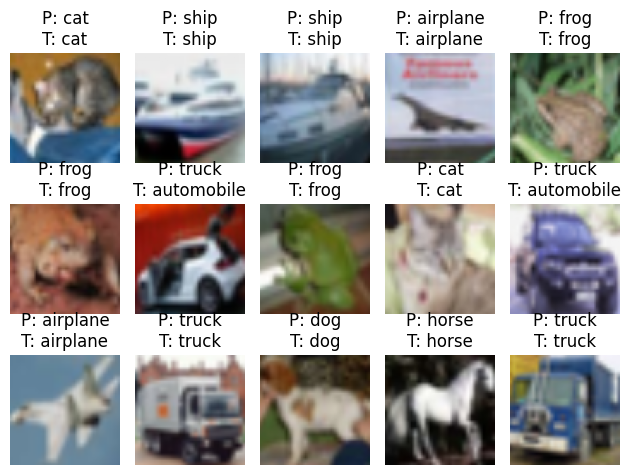

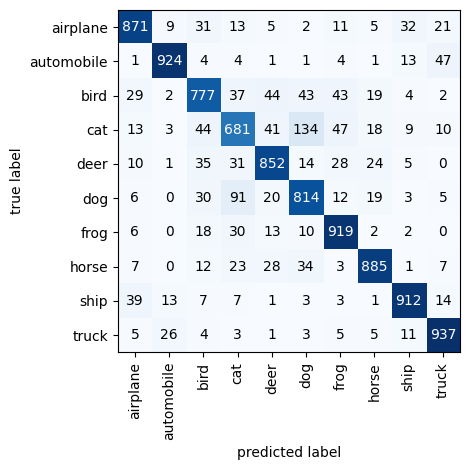

In [13]:
## Confusion matrix and examples VGG 16
model_16.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model_16, data_loader=test_loader_64, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_16, data_loader=test_loader_64, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())

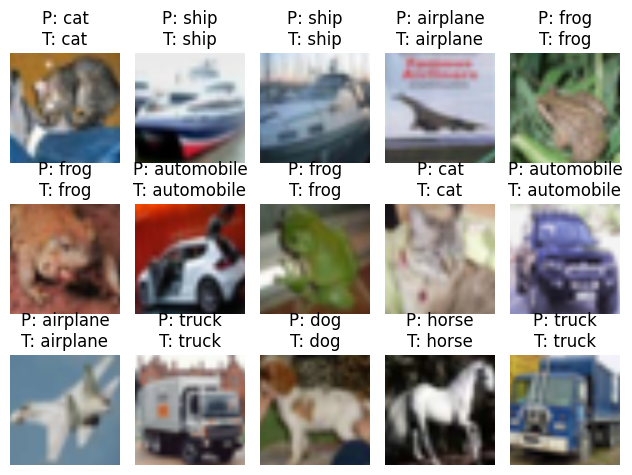

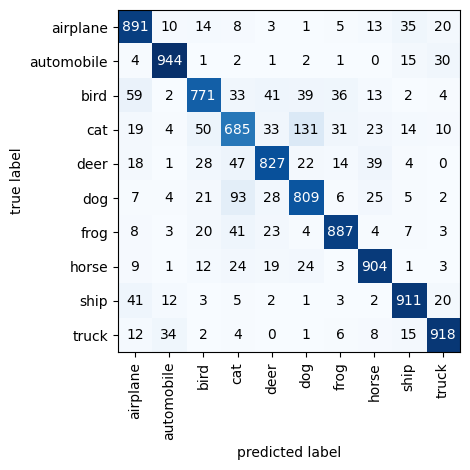

In [14]:
## Confusion matrix and examples VGG 23
model_23.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model_23, data_loader=test_loader_128, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_23, data_loader=test_loader_128, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
